In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier
import sys
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import Draw

# Citing sklearn
# https://scikit-learn.org/stable/about.html

# Citing numpy
# https://numpy.org/citing-numpy/

# Citing matplotlib
# https://matplotlib.org/stable/users/project/citing.html

# Citing pandas
# https://pandas.pydata.org/about/citing.html

# Citing rdkit
# https://sourceforge.net/p/rdkit/mailman/message/26960771/

In [3]:
CLEAN_EVERYTHING = True

if CLEAN_EVERYTHING:
    def clean_molecule(m): # https://github.com/rdkit/rdkit/issues/46 (because I'm using this on broken substructures)
        Chem.SanitizeMol(m,sanitizeOps=Chem.SanitizeFlags.SANITIZE_ALL^Chem.SanitizeFlags.SANITIZE_KEKULIZE)
else:
    def clean_molecule(m): # https://github.com/rdkit/rdkit/issues/46 (because I'm using this on broken substructures)
        Chem.SanitizeMol(m,sanitizeOps=Chem.SanitizeFlags.SANITIZE_SETAROMATICITY)


In [4]:
df = pd.read_excel('SixC-Ring SMILES final chemical library v3.xlsx')
df.drop(columns=df.columns[3:],inplace=True)
df.columns = ['smiles', 'names', 'label']
df['label'] = [i[0] == 'a' for i in df['label']]


bits = int(2048)

smiles = df['smiles']
names = df['names']
molecs = [Chem.MolFromSmiles(i, sanitize=False) for i in smiles]
[clean_molecule(s) for s in molecs]
[i.SetProp("_Name",j) for i,j in zip(molecs,names)]
molecs = [i for i in molecs if not i == None]
fingerprint = np.array([AllChem.GetMorganFingerprintAsBitVect(i,2,useChirality=True,nBits=bits) for i in molecs])


label = df['label']
tot = len(label)
pos = sum(label)
neg = tot - sum(label)

features = np.all(fingerprint == 0,axis=0) + np.all(fingerprint == 1,axis=0) == 0
print('Features:',features.sum())

print()
# print(df)
print(f"FULL Dataset: {df.shape}")
print("Fingerprint:",fingerprint.shape,"Sparcity:",np.mean(fingerprint))


Features: 795

FULL Dataset: (173, 3)
Fingerprint: (173, 2048) Sparcity: 0.01209131141618497


# Model Choice

In [26]:
def get_info():
    trialsp = 1
    trialsn = 1

    print('SGD')

    print(fingerprint.shape)
    print(label.shape)

    individual = lambda bias: SGDClassifier(loss='modified_huber', penalty='elasticnet', max_iter=1000, class_weight={0: bias, 1: 1}, warm_start=True, early_stopping=False, n_jobs=-1)
    getmodel = lambda bias: [individual(bias) for _ in range(1000)]


    model = getmodel(0.005)
    for _ in range(10):
        [i.fit(fingerprint[:,features],label) for i in model]
        print("model fit!")
        def model_on_list(smiles):
            molecs = [Chem.MolFromSmiles(i, sanitize=False) for i in smiles]
            [clean_molecule(s) for s in molecs]
            fingerprint = np.array([AllChem.GetMorganFingerprintAsBitVect(i,2,useChirality=True,nBits=bits) for i in molecs])[:,features]
            return np.mean([i.predict_proba(fingerprint)[:,1] for i in model],axis=0)
        train_reslt = model_on_list(smiles)
        predictions = np.array(train_reslt) - np.array(label)
        print('Largest error on training data:',max(abs(predictions)))
        print('Mean error on training data:',np.mean(abs(predictions)))
        print('Median error on training data:',np.median(abs(predictions)))


    for _ in range(6):

        def test_model(i):
            short_finger = list(fingerprint[:i%pos]) + list(fingerprint[(i%pos)+1:])
            model = getmodel(0.005)
            model.fit(short_finger,label[1:])
            print('.',end='')
            return model.score([fingerprint[i%pos]],[1])/trialsp/pos
        correct1 = sum(map(test_model,range(trialsp*pos)))
        print(f"+{round(correct1,2)}",end='')
        # print(f"model acccuracy for posatives: {correct1}")
        def test_model(i):
            short_finger = list(fingerprint[:pos+(i%neg)]) + list(fingerprint[pos+1+(i%neg):])
            model = getmodel(0.005)
            model.fit(short_finger,label[:-1])
            print('.',end='')
            return model.score([fingerprint[pos+(i%neg)]],[0])/trialsn/neg
        correct0 = sum(map(test_model,range(trialsn*neg)))
        print(f"-{round(correct0,2)}",end='')
        # print(f"model acccuracy for negatives: {correct0}")
        ppv = correct1*pos/(correct1*pos+(1-correct0)*neg)
        # print(f"P(1 | predict 1) = P(predict 1 | 1) P(1) / P(predict 1) = {ppv}")
        print(f"\n#  {len(fingerprint[0])}: ({round(correct1,2)}, {round(correct0,2)}, {round(ppv,2)})")
        print('done!')

# 10*SGDClassifier(loss='modified_huber', class_weight={0: 0.005, 1: 1}, validation_fraction=sys.float_info.min,n_jobs=-1)
#  2048: (0.7, 0.82, 0.19)
#  2048: (0.6, 0.79, 0.15)
#  2048: (0.7, 0.82, 0.19)

# 10*SGDClassifier(loss='modified_huber', penalty='elasticnet', class_weight={0: 0.005, 1: 1}, validation_fraction=sys.float_info.min,n_jobs=-1)
#  2048: (0.9, 0.83, 0.24)
#  2048: (0.8, 0.82, 0.21)
#  2048: (0.8, 0.83, 0.22)
#  2048: (0.8, 0.83, 0.23)
#  2048: (0.8, 0.82, 0.21)
#  2048: (0.8, 0.82, 0.22)
#  2048: (0.8, 0.83, 0.23)
#  2048: (0.7, 0.83, 0.21)
#  2048: (0.7, 0.84, 0.21)
#  2048: (0.7, 0.86, 0.23)
#  2048: (0.8, 0.83, 0.22)
#  2048: (0.9, 0.83, 0.25)
#  2048: (0.8, 0.82, 0.22)
#  2048: (0.7, 0.85, 0.22)
#  2048: (0.9, 0.85, 0.27)

# 100*SGDClassifier(loss='modified_huber', penalty='elasticnet', class_weight={0: 0.005, 1: 1}, validation_fraction=sys.float_info.min,n_jobs=-1)
#  2048: (0.8, 0.85, 0.25)
#  2048: (0.8, 0.85, 0.25)
#  2048: (0.8, 0.85, 0.25)
#  2048: (0.8, 0.84, 0.24)
#  2048: (0.8, 0.84, 0.24)
#  2048: (0.8, 0.85, 0.25)

# 1000*SGDClassifier(loss='modified_huber', penalty='elasticnet', class_weight={0: 0.005, 1: 1}, validation_fraction=sys.float_info.min,n_jobs=-1)
#  2048: (0.8, 0.87, 0.27)
#  2048: (0.8, 0.85, 0.25)
#  2048: (0.8, 0.85, 0.25)


print(f"CLEAN_EVERYTHING-{CLEAN_EVERYTHING}")
get_info()

CLEAN_EVERYTHING-True
SGD
(173, 2048)
(173,)
model fit!
Largest error on training data: 0.9762670749391608
Mean error on training data: 0.19226007350688024
Median error on training data: 0.08303180988953311
model fit!
Largest error on training data: 0.8250756698004181
Mean error on training data: 0.3279807134420314
Median error on training data: 0.29382878213069824


# Minimal Smiles

In [70]:

individual = lambda bias: SGDClassifier(loss='modified_huber', penalty='elasticnet', max_iter=1000, class_weight={0: bias, 1: 1}, warm_start=True, early_stopping=False, n_jobs=-1)
getmodel = lambda bias: [individual(bias) for _ in range(1000)]
model = getmodel(0.005)
print("model built!")
[i.fit(fingerprint[:,features],label) for i in model]
print("model fit!")
def model_on_list(x):
    molecs = [Chem.MolFromSmiles(i, sanitize=False) for i in x]
    [clean_molecule(s) for s in molecs]
    fingerprint = np.array([AllChem.GetMorganFingerprintAsBitVect(i,2,useChirality=True,nBits=bits) for i in molecs])[:,features]
    return np.mean([i.predict_proba(fingerprint)[:,1] for i in model],axis=0)

train_reslt = model_on_list(smiles)
predictions = np.array(train_reslt) - np.array(label)
print('Largest error on training data:',max(abs(predictions)))
print('Mean error on training data:',np.mean(abs(predictions)))
print('Median error on training data:',np.median(abs(predictions)))

model built!
model fit!
Largest error on training data: 0.9717560485348167
Mean error on training data: 0.1862802939220966
Median error on training data: 0.07736735823802685


In [71]:
def submolecules(molecule):
    submolecules = set([molecule])
    molecule = Chem.MolFromSmiles(molecule, sanitize=False)
    clean_molecule(molecule)
    
    atoms = [i for i in molecule.GetAtoms() if i.GetAtomicNum() != 1]
    atoms.sort(key=lambda x: x.GetIdx(),reverse=True)
    numatoms = len(atoms)
    print(f'Generating {2**numatoms - 2} submolecules using {numatoms} atoms')
    for subinds in range(1,(2**numatoms)-1):
        deletions = [((subinds//2**i)%(2**(i+1))) == 0 for i in range(numatoms)]
        # print(deletions)
        new_mol = Chem.EditableMol(molecule)
        for ind,delete in enumerate(deletions):
            if delete:
                for bond in atoms[ind].GetNeighbors():
                    new_mol.RemoveBond(atoms[ind].GetIdx(),bond.GetIdx())
        for ind,delete in enumerate(deletions):
            if delete:
                new_mol.RemoveAtom(atoms[ind].GetIdx())
        new_mol = Chem.MolToSmiles(new_mol.GetMol())
        if not new_mol in submolecules:
            print('.',end='')
            submolecules.add(new_mol)
    print(f'\nReturning {len(submolecules)} unique submolecules')
    return submolecules



print(f"CLEAN_EVERYTHING-{CLEAN_EVERYTHING}")
main_mols = []
legend = []
for molecule_tested in range(len(smiles)):
    pred = model_on_list([smiles[molecule_tested]])[0]
    print(f"{molecule_tested}/{len(smiles)}\t{names[molecule_tested]}:\t{smiles[molecule_tested]}\t--\tscore = {round(pred,2)}")

    starter = Chem.MolFromSmiles(smiles[molecule_tested], sanitize=False)
    clean_molecule(starter)
    substructs = 2**len([i for i in starter.GetAtoms() if i.GetAtomicNum() != 1]) - 2
    if substructs > 10**5:
        print(f"{substructs} substructures is to many :'(")
        continue

    pcut = 0.5

    # if pred < pcut:
    #     print("WARNING: FULL MOLECULE PREDICTED NOT TO BIND\n\tSCORE = ",round(pred,2))

    # print("running exhaustive search...")
    subs = submolecules(smiles[molecule_tested])
    # print(f"found {len(subs)} submolecules...:{subs}")
    passing_subs = [(i,j,) for i,j in zip(model_on_list(subs),subs) if i > pcut]
    print(f"Found {len(passing_subs)} posative submolecules!")

    template = Chem.MolFromSmiles(smiles[molecule_tested])
    AllChem.Compute2DCoords(template)
    # for i,n in enumerate(passing_subs):
    #     print(f"Submolecule {i}:\tScore = {round(n[0],2)}\t{n[1]}")
    mMols = [Chem.MolFromSmiles(smiles[molecule_tested], sanitize=False)] + [Chem.MolFromSmiles(m[1], sanitize=False) for m in passing_subs]
    clean_molecule(mMols[0])
    # if pred < pcut:
    #     print("WARNING: FULL MOLECULE PREDICTED NOT TO BIND\n\tSCORE = ",round(pred,2))
        
    print('Done!')

    fragments = [mMols[0].GetSubstructMatches(m,maxMatches=100000000,useChirality=True) for m in mMols[1:]]
    for at in mMols[0].GetAtoms():
        overlaps = [max([at.GetIdx() in f for f in i]+[0]) for i in fragments]
        at.SetProp('atomNote',f"{round(sum(overlaps)/(len(fragments)+sys.float_info.min),2)}")
        
    main_mols.append(mMols[0])
    legend.append(f"{smiles[molecule_tested]}\n{names[molecule_tested]}\n{len(fragments)} successfull submolecules")

print(f"CLEAN_EVERYTHING-{CLEAN_EVERYTHING}")
Draw.MolsToGridImage(main_mols,legends=legend, maxMols=100000000, molsPerRow=5, subImgSize=(250,250), useSVG=True)

CLEAN_EVERYTHING-True
0/173	C1[C@H]([C@H]([C@@H]([C@](O1)(CO)O)O)O)O[C@@H]2[C@@H]([C@H]([C@@H]([C@H](O2)CO)O)O)O:	O[C@@H](CNC)[C@H]([C@@H]([C@@H](CO)O)O)O	--	score = 1.0
Generating 8190 submolecules using 13 atoms
.........................................................................................................................................................................
Returning 170 unique submolecules
Found 101 posative submolecules!
Done!
1/173	CC1(OCC(O1)[C@@H]2C[C@@H]3[C@H](O2)OC(O3)(C)C)C:	O[C@H]1[C@H](O)[C@H](O)C(O)O[C@@H]1CO	--	score = 0.99
Generating 4094 submolecules using 12 atoms
....................................................................................................................................
Returning 133 unique submolecules
Found 20 posative submolecules!
Done!
2/173	C1[C@H]([C@H]([C@@H](C(O1)(CO)O)O[C@@H]2[C@@H]([C@H]([C@@H]([C@H](O2)CO)O)O)O)O)O:	OC[C@H](COP(O)(O)=O)O	--	score = 1.0
Generating 1022 submolecules using 10 atoms
...............

# Scoring Catalogs

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

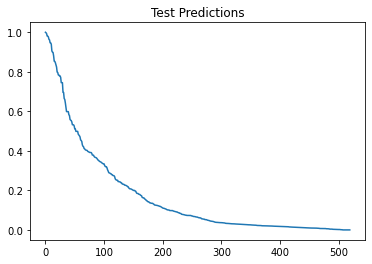

Hits: 52


In [65]:
nums = []

file = 'SantaCruztBioTechStockListCarbohydratesFiltered_v6.csv'
df = pd.read_csv(file, dtype=str)
inp = list(df['SMILES'])
for _ in range(1000):
    model = SGDClassifier(loss='modified_huber', penalty='elasticnet', max_iter=1000, class_weight={0: 0.005, 1: 1}, warm_start=True, early_stopping=False, n_jobs=-1)
    model.fit(fingerprint[:,features],label)
    def model_on_list(smiles):
        molecs = [Chem.MolFromSmiles(i, sanitize=False) for i in smiles]
        [clean_molecule(s) for s in molecs]
        fingerprint = np.array([AllChem.GetMorganFingerprintAsBitVect(i,2,useChirality=True,nBits=bits) for i in molecs])[:,features]
        return model.predict_proba(fingerprint)[:,1]
    predictions = model_on_list(inp)
    nums += [predictions]

    print('.',end='')


nums = np.array(nums)
predictions = [nums.mean(axis=0),nums.std(axis=0)/np.sqrt(len(nums)),np.array(df['Name']),np.array(df['SMILES'])]

plt.plot(sorted(predictions[0],reverse=True))
plt.title('Test Predictions')
plt.show()

posatives = sorted(list(zip(*[i[predictions[0]>0.5] for i in predictions])),reverse=True)
nhits = len(posatives)
print('Hits:',nhits)
x = pd.DataFrame(posatives)
x.columns=['Score','SE','Name','SMILES']
x.to_excel(file[:file.find('.')]+'-Hits.xlsx',index=False)

mMols = [Chem.MolFromSmiles(m[3]) for m in posatives]
x = Draw.MolsToGridImage(mMols,legends=[f'Molecule {i}\tScore = {round(posatives[i][0],2)} +/- {round(posatives[i][1],2)}\n{posatives[i][2]}' for i in range(nhits)], molsPerRow=9, maxMols = 100, subImgSize=(300,300), returnPNG=False)
x.save(file[:file.find('.')]+'-Hits.png')